## Visualizing Vast Data

The main drive for this project is to visualize the World Bank's data in one graph. I feel a duty to unpack the relationship between data and their "truths".

Data science is making a mistake by not investing in visualization. Often, I recall climbing and staring up at Yosemite's 2000 foot granite walls. After many days, a noticable shift occured in my perception, and I began to *feel* the vastness of the rock differently from before. I would like to see decision-makers regard their data in this way. 

Rich, high quality plots have more to offer decision-makers than we realize, and I will explore that notion with this project.

In [4]:
### Setup ###
from csv import reader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat

from pandasql import *
#! pip install psycopg2-binary

filepath = "/Users/zachpolitz/Desktop/WorldBank_ESG.csv"

### Open data file ###
ESG_opened = open(filepath)
ESG_read_csv = pd.read_csv(ESG_opened)
ESG_raw = pd.DataFrame(ESG_read_csv)
ESG_cols = ESG_raw.columns

In [5]:
### Move '1961' after '1960' ###
sixty_one = ESG_raw['1961']
ESG_raw.drop(['1961'], axis = 1,inplace = True)
ESG_raw.insert(loc = 5, column = '1961', value = 0)
ESG_raw['1961'] = sixty_one

### Drop unused columns ###
ESG_raw = ESG_raw.drop(['Country Code','Indicator Code','2050'], axis = 1)

### Extract header from first row of data ###

### Separate country and regional data ###
ESG_by_country = ESG_raw.iloc[3082:]
ESG_by_region = ESG_raw.iloc[0:3082]

### First, I'll get a basic overview of the dataset: 

In [4]:
ESG_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16013 entries, 0 to 16012
Data columns (total 63 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    16013 non-null  object 
 1   Indicator Name  16013 non-null  object 
 2   1960            1356 non-null   float64
 3   1961            1955 non-null   float64
 4   1962            2192 non-null   float64
 5   1963            1966 non-null   float64
 6   1964            1978 non-null   float64
 7   1965            2017 non-null   float64
 8   1966            2018 non-null   float64
 9   1967            2260 non-null   float64
 10  1968            2037 non-null   float64
 11  1969            2048 non-null   float64
 12  1970            3084 non-null   float64
 13  1971            3589 non-null   float64
 14  1972            3833 non-null   float64
 15  1973            3585 non-null   float64
 16  1974            3596 non-null   float64
 17  1975            3935 non-null  

### Immediately I notice a number of things:
- Data collection occured from 1960 to 2020
- All data types are floats (decimals)
- The number of non-null data points (reported metrics) increases steadily until 2015, at which time reporting drops dramatically.

In [5]:
print(ESG_raw.head())
print('\n')
print(ESG_raw.tail())

  Country Name                                     Indicator Name  1960  \
0   Arab World  Access to clean fuels and technologies for coo...   NaN   
1   Arab World            Access to electricity (% of population)   NaN   
2   Arab World  Adjusted savings: natural resources depletion ...   NaN   
3   Arab World  Adjusted savings: net forest depletion (% of GNI)   NaN   
4   Arab World                 Agricultural land (% of land area)   NaN   

        1961       1962       1963       1964       1965       1966  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4  27.835643  27.826564  27.845522  27.847925  27.866972  27.866171   

        1967  ...       2011       2012       2013       2014       2015  \
0        NaN  ...  82.783218  83.120096  83.53

### Looking at the first and last rows, it appears that data were collected for regions, as well as individual countries. I also see that some values were filled in with 'NaN' or "Not a Number". 

Next step: Extract query-able terms
- Split the dataset into countries and regions. 
- Get all unique years
- Get all unique regions
- Get all unique countries
- Get all unique indicators 

In [6]:
### Separate country and regional data 
ESG_by_country = ESG_raw.iloc[3082:]
ESG_by_region = ESG_raw.iloc[0:3082]

In [6]:
### Create lists of unique years, indicies, and countries 
ESG_indicies = ESG_raw['Indicator Name'].unique()
ESG_years = ESG_raw.columns[2:] # get all columns except'Country Name' and 'Indicator Name'.
ESG_countries = ESG_by_country['Country Name'].unique()
ESG_regions = ESG_by_region['Country Name'].unique()

### I want to take a closer look at the distribution of Null values, or the volume of reported values annually.

To do so, I will create three dictionaries:
- 1st   {country: {year: sum_across_indicies(nulls) }}
- 2nd   {region: {year: sum_across_indicies(nulls) }}
- 3rd   {index: {year: sum_across_countries(nulls) }}

In [7]:
### Reporting activity/ null counts {country: year: sum_across_indicies(nulls)} ###
annual_null_counts = {}

for country in ESG_countries: 
    year_raw = ESG_by_country[ESG_by_country['Country Name'] == country]
    year_nulls = {}
    for year in ESG_years:
        nulls = 0
        years_data = year_raw[year]
        for indx in years_data:
            indx = str(indx)
            # data type is float, but value prints 'nan'
            if indx == 'nan':
                nulls += 1
        year_nulls[year] = nulls
    annual_null_counts[country] = year_nulls


In [8]:
### Reporting density dictionary: {region: year: sum_across_indicies(nulls)} ###
annual_null_counts_region = {}
for region in ESG_regions: 
    year_raw = ESG_by_region[ESG_by_region['Country Name'] == region]
    year_nulls = {}
    for year in ESG_years:
        nulls = 0
        years_data = year_raw[year]
        for indx in years_data:
            indx = str(indx)
            if indx == 'nan':
                nulls += 1
        year_nulls[year] = nulls
    annual_null_counts_region[region] = year_nulls

In [9]:
### Reporting density dictionary: {index: year: sum_across_countries(nulls)}

index_nulls_annual_sum = {}
for indx in ESG_indicies:
    index_nulls_annual_sum[indx] = {}
    d_set = ESG_by_country[ESG_by_country['Indicator Name'] == indx] # One index
    for year in ESG_years:  # One year
        d_vec = d_set[year]
        d = 0
        for row in d_vec: # One country
            if str(row) == 'nan': # Is the value null?
                d+= 1
        index_nulls_annual_sum[indx][year]= d

### An Overview:

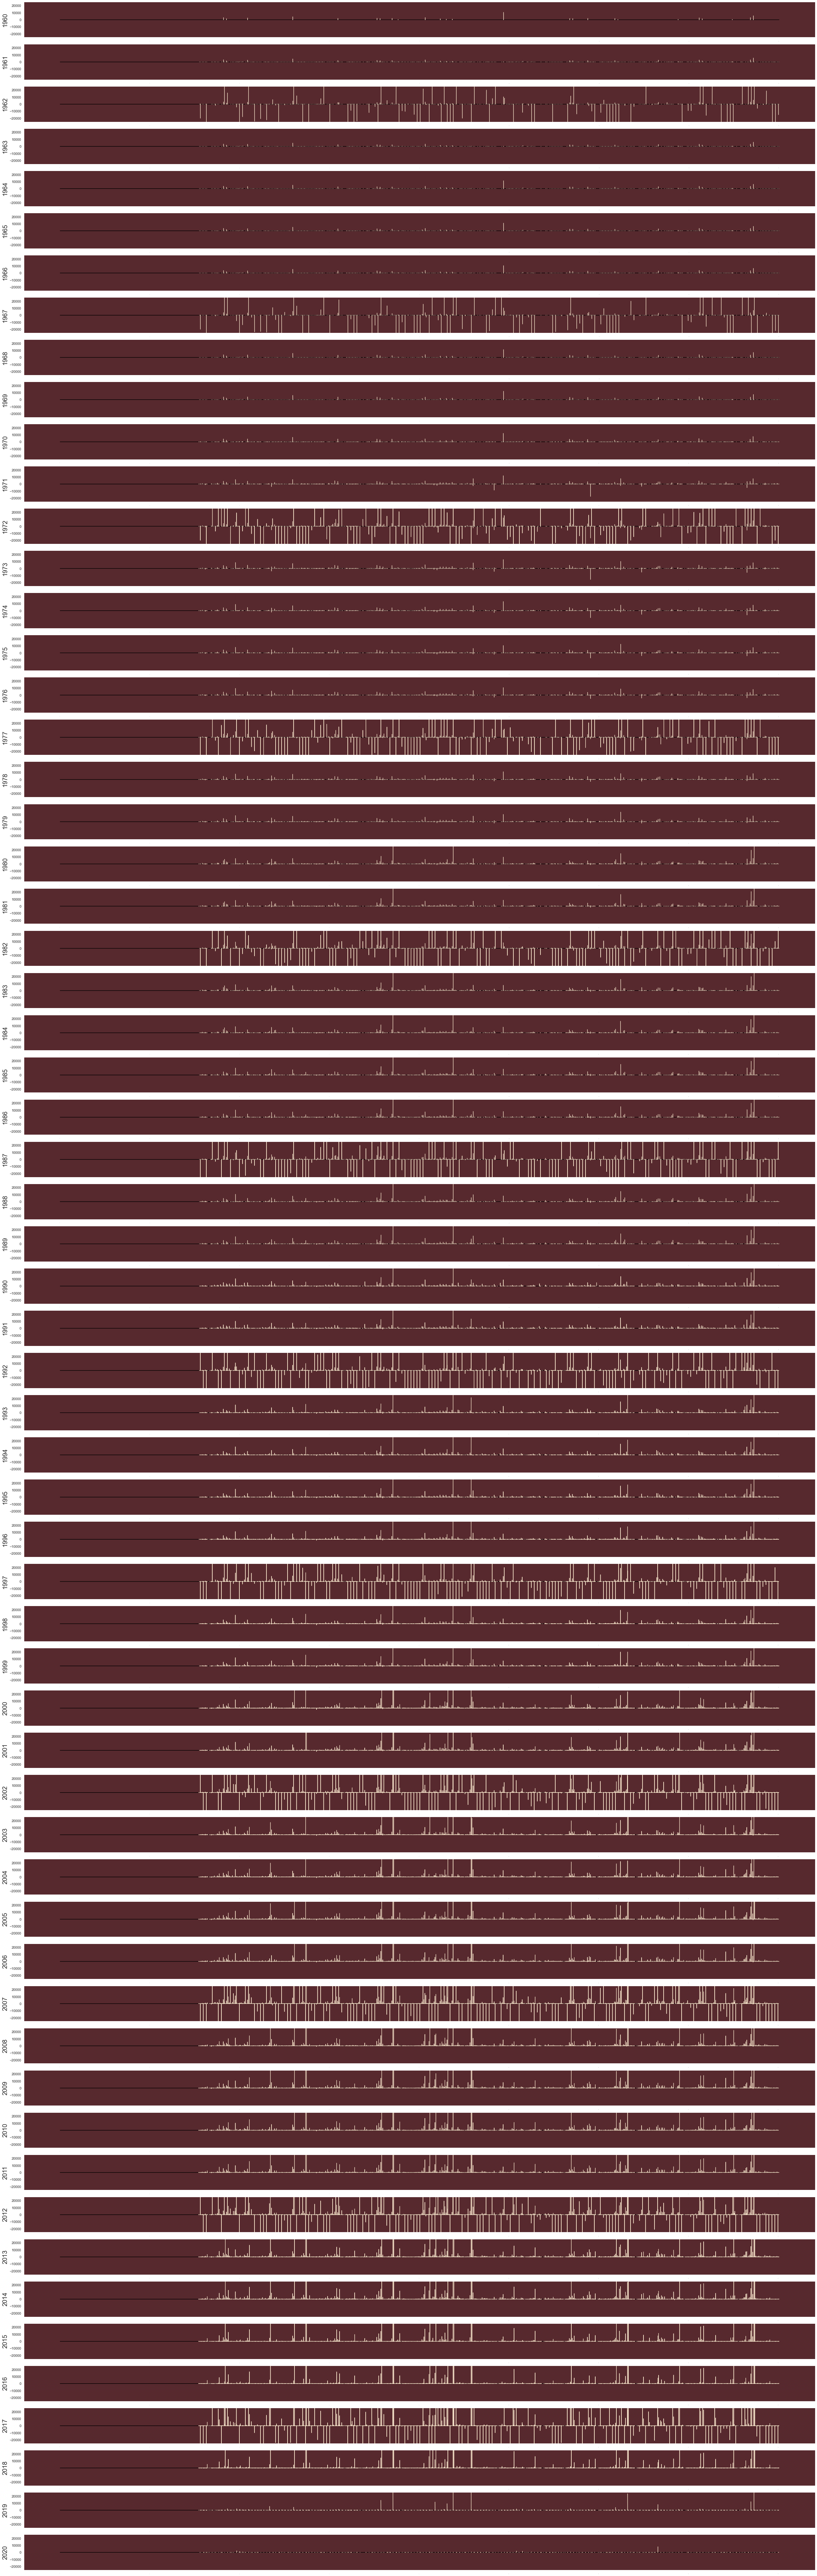

In [65]:
# Small mulitple bar charts that shows all raw values recorded each year.


# Figure setup
fig, ax = plt.subplots(len(ESG_years),1)
fig.set_figwidth(45)
fig.set_figheight(150)


for y in range (0,(len(ESG_years))):
    
    d2_set = ESG_by_country[ESG_years[y]]
    
    zero_line = np.ndarray(16000)
    zero_line.fill(0)

    
    ax[y].plot(zero_line, color = 'black',)
    ax[y].plot(d2_set, c = [.992,.922,.816])
    
    ax[y].grid(False)
    ax[y].set_title("",fontsize = 14)
    ax[y].set_ylabel(ESG_years[y], fontsize = 20)
    ax[y].tick_params(axis = 'x',labelsize = 0, bottom = False, rotation = 90)
    ax[y].tick_params(axis = 'y', left = False)

    ax[y].set_ylim(-25000,25000)
    
    ax[y].set_facecolor([.341,.160,.18])
    
    ax[y].spines['right'].set_visible(False)
    ax[y].spines['top'].set_visible(False)
    ax[y].spines['left'].set_visible(False)
    ax[y].spines['bottom'].set_visible(False)

    

# plt.show()

#### Reflections:
- Why aren't values appearing for the first ~20% of countries?
- 5 year cycle of reporting large magnitude values
- Over time, bar height increases globally.

## Plotting nulls:
- Plotting nulls will only visualize whether data was reported, rather than the value reported.

2806 46


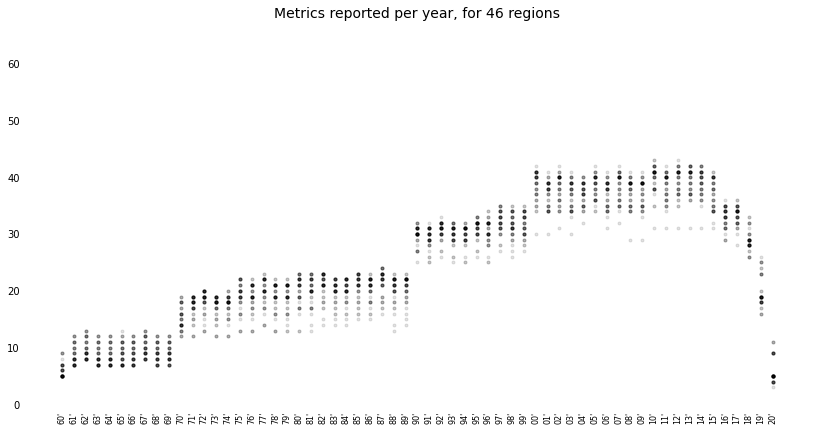

In [19]:
### number of reported metrics for each region, by year.

x=[]
y=[]

for year in ESG_years:
    for region in ESG_regions:
        year_string = str(year)
        x.append(year_string[-2:] + "'")
        y.append(67-annual_null_counts_region[region][year])

print(len(y),len(ESG_regions))
fig, ax = plt.subplots()

fig.set_figwidth(14)
fig.set_figheight(7)

ax.set_title("Metrics reported per year, for 46 regions",fontsize = 14)
ax.set_ylabel("")
ax.tick_params(axis = 'x',labelsize = 8, bottom=False, rotation = 90)
ax.tick_params(axis = 'y', left=False)

ax.set_ylim(top=67)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.scatter(x,y,marker = '.',c = 'black',alpha=.11)

plt.show()

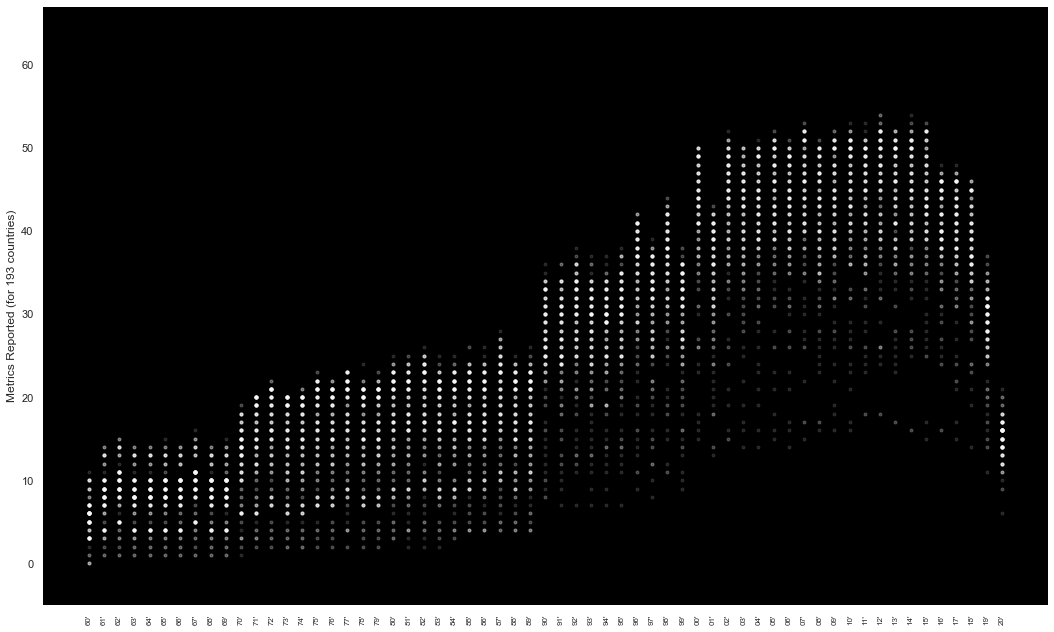

In [69]:
### number of reported metrics for each country, by year. Each dot 

x=[]
y=[]

for year in ESG_years:
    for country in ESG_countries:
        year_string = str(year)
        x.append(year_string[-2:] + "'")
        y.append(67-annual_null_counts[country][year])
 
    
fig, ax = plt.subplots()
fig.set_figwidth(18)
fig.set_figheight(11)

ax.set_ylim(bottom = -5, top=67)
ax.set_ylabel("Metrics Reported (for 193 countries)")

ax.tick_params(axis = 'x',labelsize = 8, bottom=False, rotation = 90)
ax.tick_params(axis = 'y', left=False)

ax.grid(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_facecolor('black')

ax.scatter(x,y,marker = '.',c='white', alpha = .12)
plt.show()

#### Reflection:
- This kind of simple complexity is what I'm striving for, but it should contain more data.

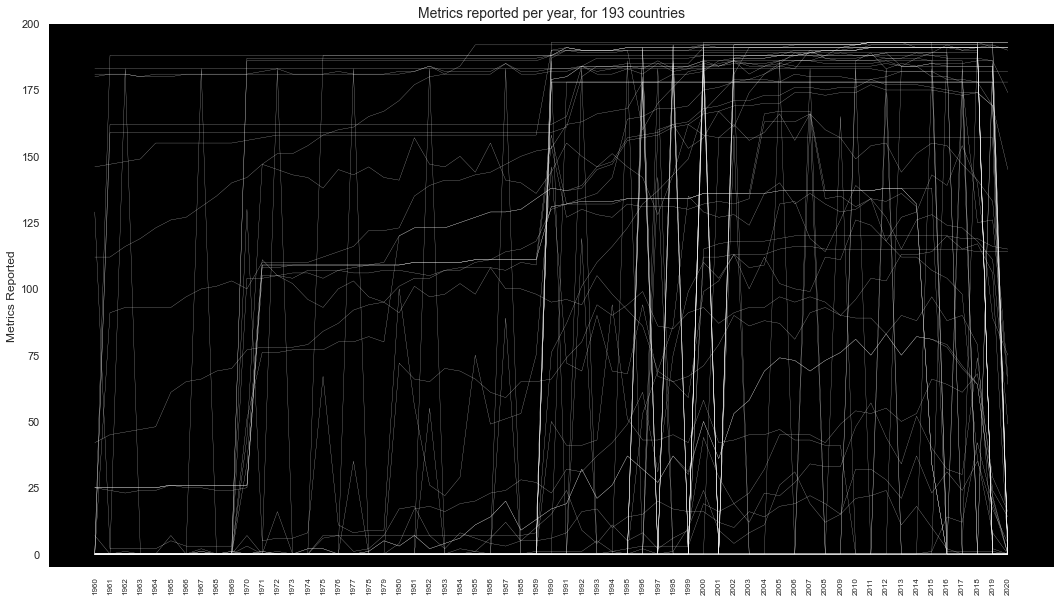

In [71]:
fig, ax = plt.subplots()
fig.set_figwidth(18)
fig.set_figheight(10)
ax.set_ylim(top=200,bottom = -5)
ax.set_ylabel("Metrics Reported")
ax.tick_params(axis = 'x',labelsize = 8, bottom=False, rotation = 90)
ax.tick_params(axis = 'y', left=False)

ax.set_title("Metrics reported per year, for 193 countries",fontsize = 14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.grid(False)

index_count = 0
for indx in ESG_indicies:
    x = []
    y = []
    for year in ESG_years:
        d = index_nulls_annual_sum[indx][year]
        x.append(193 - d)
        y.append(year)
    ax.plot(y,x, c = 'white', lw = .2)

ax.set_facecolor('black')
   

#### Reflection:
- many metrics were recorded in cycles, showing rhythmic spikes.
- There are metrics that have consistently recieved reporting, and some that have poor adherence.
- A handfull of metrics have had high levels of reporting since the beginning.

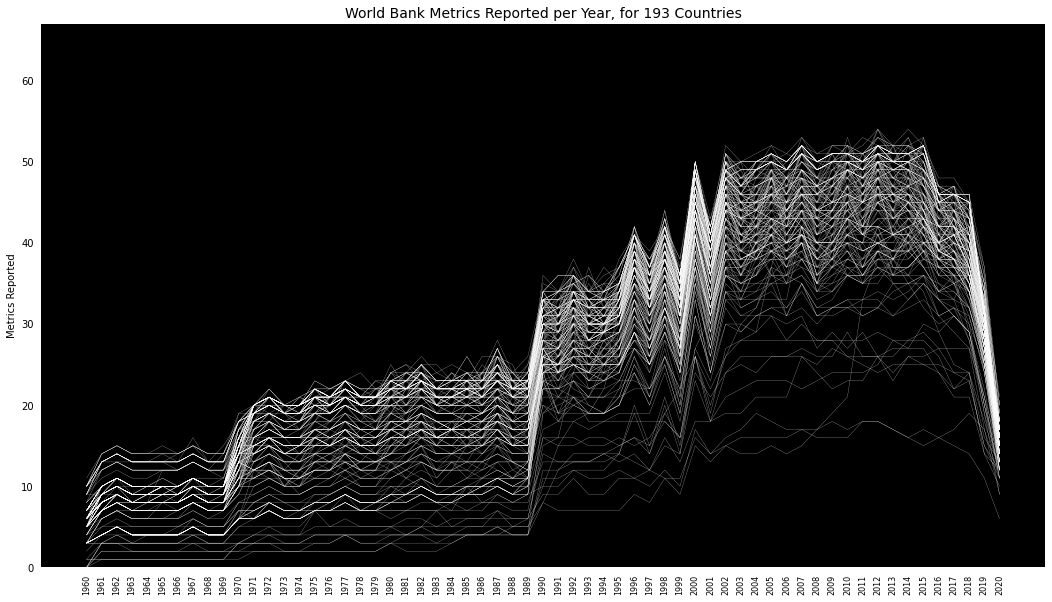

In [23]:
### Plot Line Graph for every country's number of metrics reported

fig, ax = plt.subplots()
fig.set_figwidth(18)
fig.set_figheight(10)
ax.set_ylim(top=67)
ax.set_ylabel("Metrics Reported")
ax.tick_params(axis = 'x',labelsize = 8, bottom=False, rotation = 90)
ax.tick_params(axis = 'y', left=False)

ax.set_title("World Bank Metrics Reported per Year, for 193 Countries",fontsize = 14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

country_count = 0
for country in ESG_countries:
    x = []
    y = []
    for year in ESG_years:
        d = annual_null_counts[country][year]
        x.append(67 - d)
        y.append(year)
    ax.plot(y,x, c = 'white', lw = .2)
    country_count += 1
ax.set_facecolor('black')

#### Reflection:

- World bank has made movements as an organization that influence the metrics recoreded by all countries: 69'-71',89', 95'-03', 15'-20'
- While reporting volume increased over the years, it became much more chaotic after the nineties. 
- There have always been a layer of countries that were reporting some metrics, but not all of the metrics offfered.
- The World Bank lists 67 different metrics, but never recieved over 55 inputs.
- All metrics began dropping off after 2018.

### Poltting Reported Values:

#### Many indicies have units that, unstandardized, will be incompatible on a graph with other indicies.

#### A large proportion of indicies provide percentages, which will let me merge them without standardization.

#### Phrasing for SQL
- 'Country Name'  'Indicator Name'

In [11]:
ESG_countries

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic',
       'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador',
       'Egypt, Arab Rep.', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia, The', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Gu

In [10]:
# SQL 
# - Can I feed it variables from a loop?
# - When is SQL simpler than Pandas?
# - I would like to deconstruct a dataset for downstream reconstruction

# What am I doing: 
sql_d = sqldf("""
SELECT * FROM ESG_by_country E
WHERE E.'Country Name' LIKE "United States"
""", globals())

sql_d

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 63 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    67 non-null     object 
 1   Indicator Name  67 non-null     object 
 2   1960            10 non-null     float64
 3   1961            13 non-null     float64
 4   1962            14 non-null     float64
 5   1963            13 non-null     float64
 6   1964            13 non-null     float64
 7   1965            14 non-null     float64
 8   1966            13 non-null     float64
 9   1967            14 non-null     float64
 10  1968            13 non-null     float64
 11  1969            13 non-null     float64
 12  1970            18 non-null     float64
 13  1971            19 non-null     float64
 14  1972            20 non-null     float64
 15  1973            19 non-null     float64
 16  1974            21 non-null     float64
 17  1975            20 non-null     float

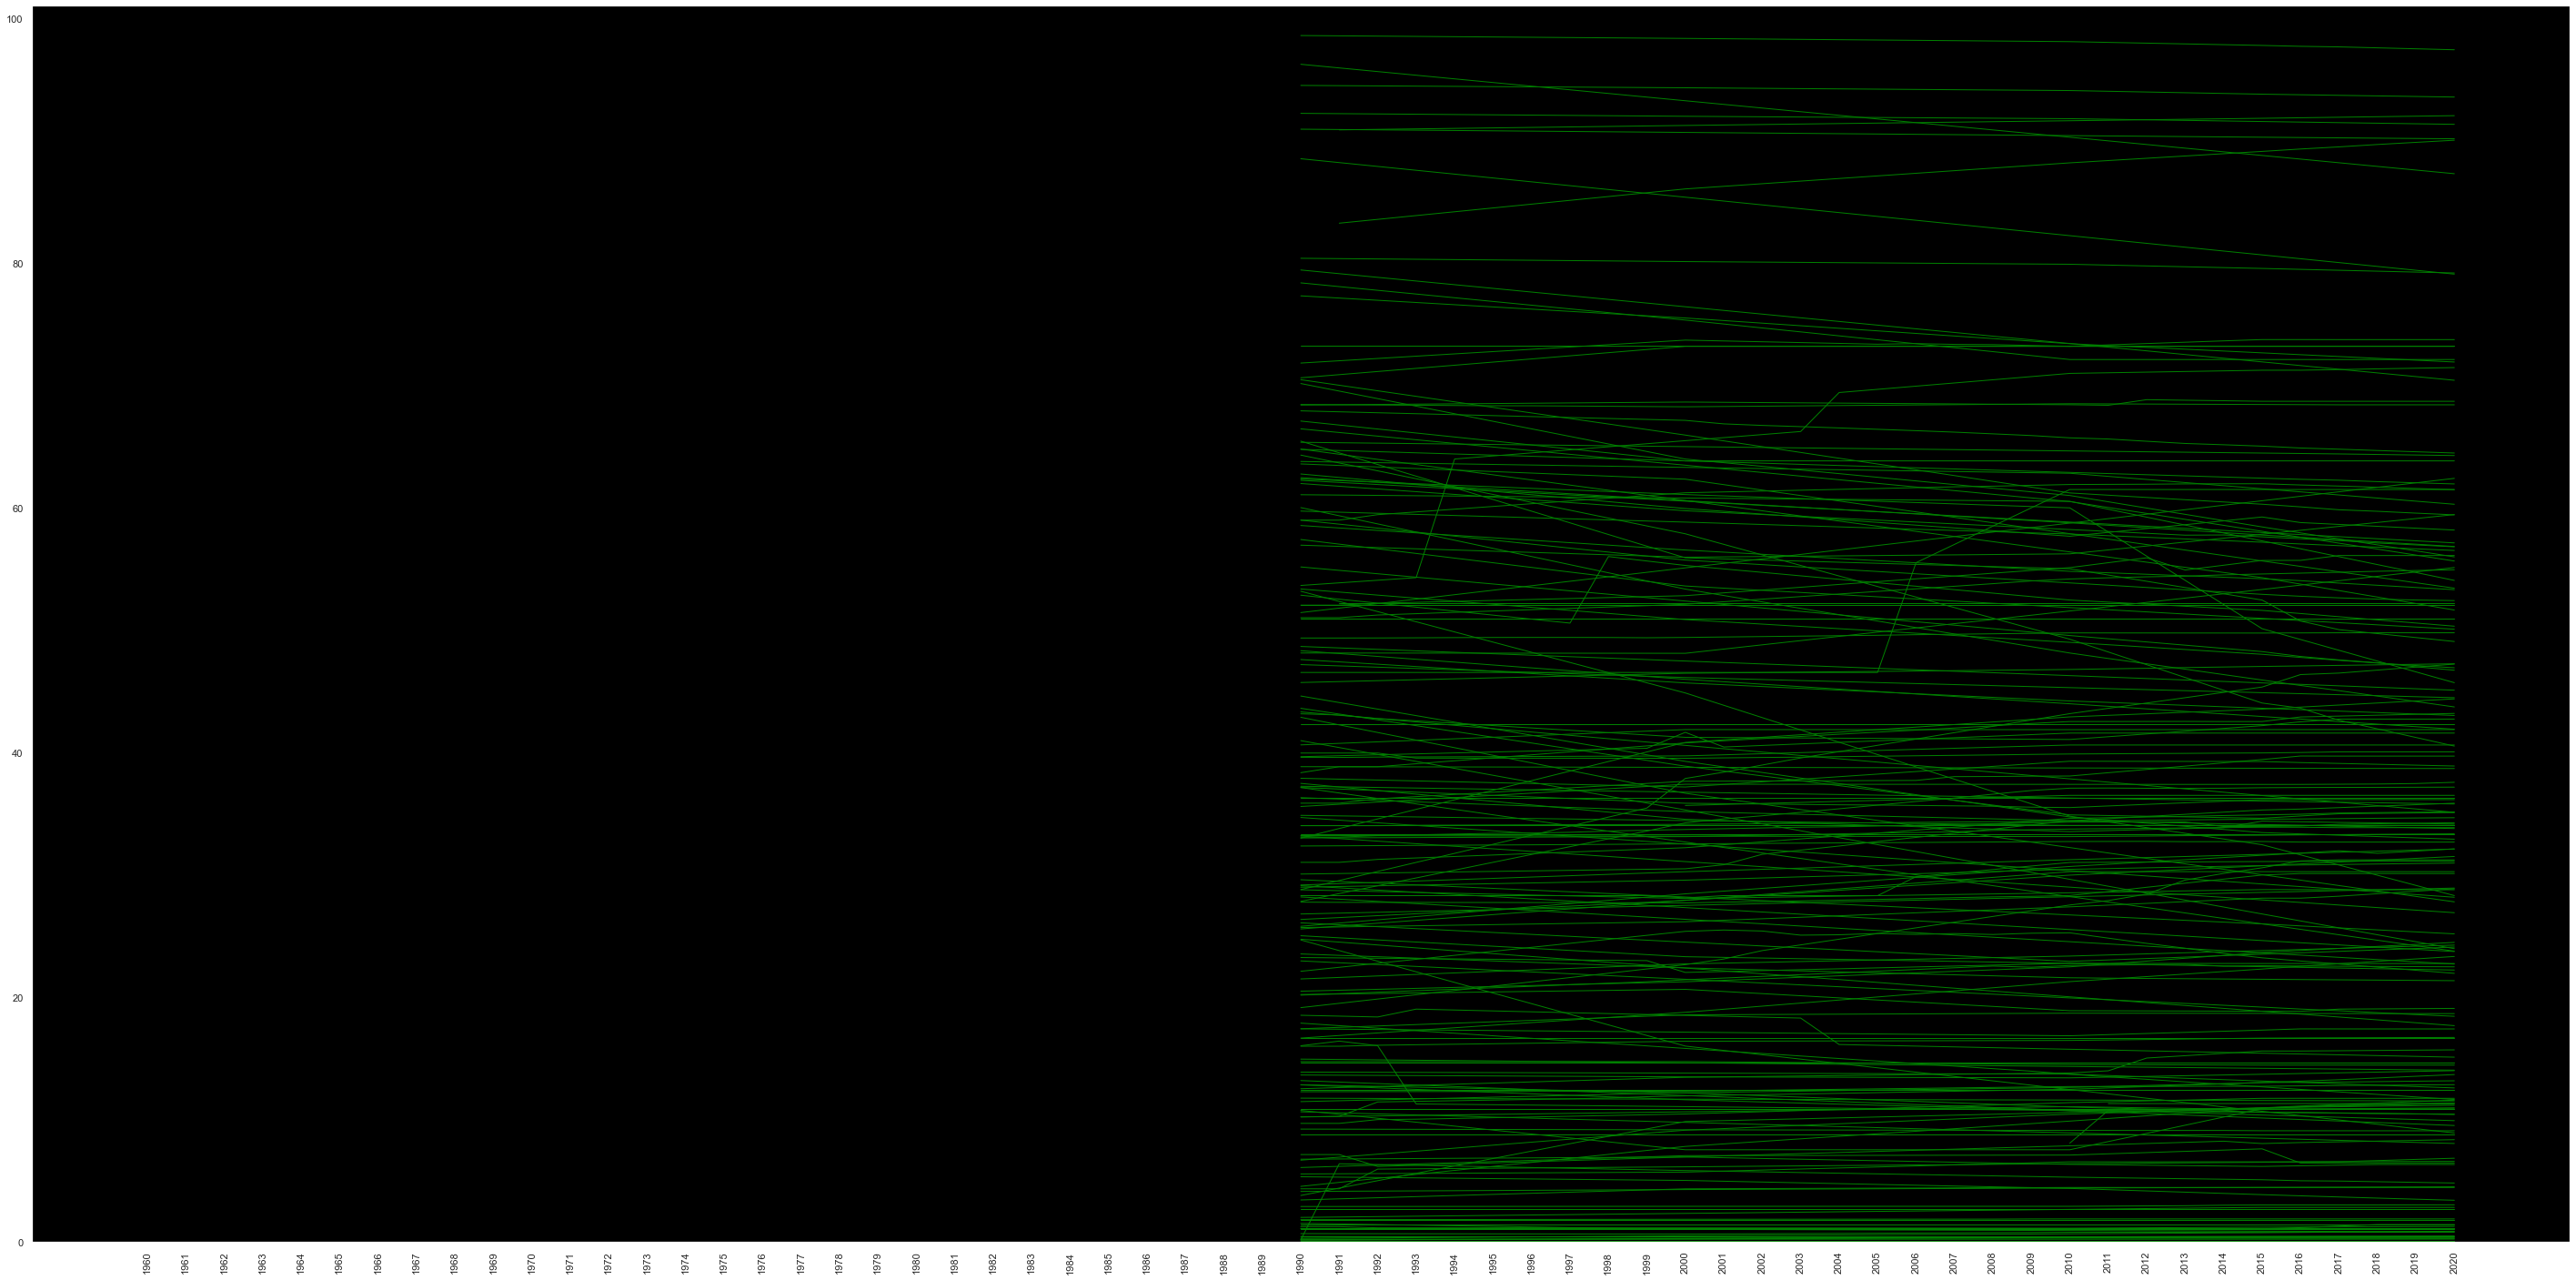

In [97]:

# Internet, renewables, pop_den

c_water = ESG_by_country[ESG_by_country['Indicator Name'] == 'People using safely managed drinking water services (% of population)']
forested = ESG_by_country[ESG_by_country['Indicator Name'] == 'Forest area (% of land area)']
hunger = ESG_by_country[ESG_by_country['Indicator Name'] == 'Prevalence of undernourishment (% of population)']
poverty = ESG_by_country[ESG_by_country['Indicator Name'] == 'Poverty headcount ratio at national poverty lines (% of population)']
life_expec = ESG_by_country[ESG_by_country['Indicator Name'] == 'Life expectancy at birth, total (years)']
internet = ESG_by_country[ESG_by_country['Indicator Name'] == 'Individuals using the Internet (% of population)']
renewable = ESG_by_country[ESG_by_country['Indicator Name'] == 'Renewable electricity output (% of total electricity output)']
density = ESG_by_country[ESG_by_country['Indicator Name'] == 'Population density (people per sq. km of land area)']
countries = ESG_countries

fig, ax = plt.subplots()
fig.set_figwidth(50)
fig.set_figheight(25)
ax.set_ylim(top=105,bottom = -5)
ax.tick_params(axis = 'x',rotation = 90)

fill_x = []
fill_y = []
for row in ESG_years:
    fill_x.append(row)
    fill_y.append(0)

    
for country in countries:
    f = forested[forested['Country Name'] == country]
    i = internet[internet['Country Name'] == country]
    r = renewable[renewable['Country Name'] == country]
    
    f_plot = []
    i_plot = []
    r_plot = []
    for year in ESG_years:
        f_plot.append(f[year])
        i_plot.append(i[year])
        r_plot.append(r[year])
    
    ax.scatter(fill_x,fill_y,alpha = 0)
    ax.plot(fill_x,f_plot, c = 'green', lw = 1, alpha = 1)
    ax.plot(fill_x,i_plot, c = 'blue', lw = .25, alpha = 0)
    ax.scatter(fill_x, r_plot, marker = ',', c = 'white', s = 25, alpha = 0)

ax.grid(False)
ax.set_ylim(0,101)
ax.set_facecolor('black')



#### Reflection:
- An astonishing adoption of the internet since the 90's.
- A fairly consistent spread of renewable energy generation, with a noticable density of countries at 100%.
- Negative trend of forested area among highly-forested countries.
- Dense lines of zero-slope at ~15% and ~35% forested area, with few countries that reside above 70%.

Polar plot:
- scatter plot: 180 degrees in a hemisphere, each year should be 3 degrees apart
- line plot: I expect simply switching from scatter() to plot() will complete this task
- histogram: greatest unknown. I don't expect the bucket size to transfer to a polar plot, unless it make it simply a line, not a rectangle.

Work:
- Get polar plotting up and running (points, lines, and bars)
- convert x values (converting years to degree value)
- convert y (%) values to distance from center ( can convert % values to( %*n, %*(n+i) ))

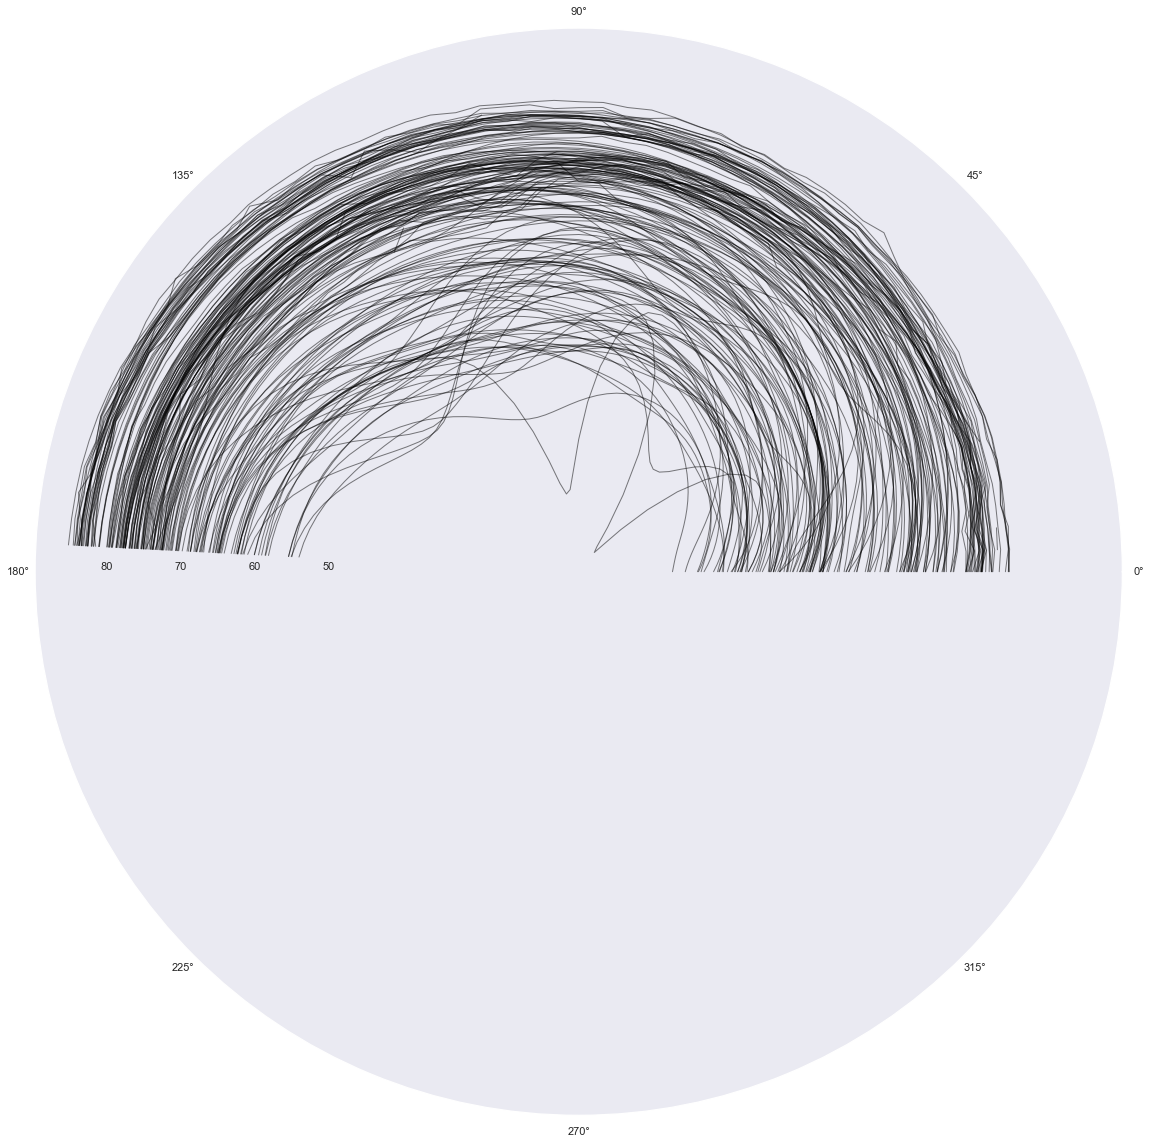

In [107]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}) # what does this do?
fig.set_figwidth(20)
fig.set_figheight(20)

# ax.set_rmax(1)
ax.set_rticks([50,60, 70, 80])  # Less radial ticks
ax.set_rlabel_position(180)  # Move radial labels away from plotted line
ax.grid(False)

# plot upper hemisphere line plot of life expectancy

max_le = []
for country in ESG_countries:
    
    le = life_expec[life_expec['Country Name'] == country]
    theta_le = []
    r_le = []
    
    for year in ESG_years:
        d = le[year]    
        r_le.append(d)
        theta_le.append(((int(year) - 1960)/120) * (2* np.pi))
    #ax.plot(theta_le, r_le, c = [.992,.922,.816], lw = 1)
    ax.plot(theta_le, r_le, c = 'black', lw = 1, alpha = .5)


# plot lower hemisphere scatter plot
for country in ESG_countries:
    theta = []
    r_null = []
    r_le = []
    for year in ESG_years:
        d = annual_null_counts[country][year]
        theta.append((180-(int(year) - 1960)/120) * (-2* np.pi))
        r_null.append(((67-d)/67)+1)
    #ax.scatter(theta,r_null, c = 'black', alpha = .1)


# ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()

#### Reflection:
- I like the circular aesthetic. 
- Comparing data in a polar format is messy.
- We can still tell that over time (0 > 180)

## Seaborn

### Scatterplot

In [109]:
# Use forested and density as scatterplot parameters
# forested = ESG_by_country[ESG_by_country['Indicator Name'] == 'Forest area (% of land area)'].transpose()
# density = ESG_by_country[ESG_by_country['Indicator Name'] == 'Population density (people per sq. km of land area)'].transpose()


sns.set(rc={'figure.figsize':(20,10)})

# extract and transpose drinking water data
water = ESG_by_country[ESG_by_country['Indicator Name'] == 'People using safely managed drinking water services (% of population)'].transpose()
density = ESG_by_country[ESG_by_country['Indicator Name'] == 'Population density (people per sq. km of land area)'].transpose()

# drop irrelevant columns
water = water[2:]
density = density[2:]
# replace column labels with empty strings
blank_column_labels = ['']*len(water.columns)
water.columns = blank_column_labels

sns.scatterplot(data=water,size = density)



ValueError: The following variable cannot be assigned with wide-form data: `size`